In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.nn.utils import spectral_norm

#Variables
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_path = r'E:\Projects\Data\VW-GAN\Images\128'  
save_path = r'E:\Projects\Data\VW-GAN\Images\Generated'   
os.makedirs(save_path, exist_ok=True)

epochs = 500
batch_size = 64
lr_g = 0.0001
lr_d = 0.0002
latent_dim = 128
img_size = 128
channels = 3
critic_iter = 5   # number of D updates per G update
lambda_gp = 10    # gradient penalty weight

# Add transformations for variety
# Convert to tensors and normalize
transform = transforms.Compose([transforms.RandomHorizontalFlip(p = 0.5),transforms.RandomRotation((-5,5)),transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])

dataset = datasets.ImageFolder(root=data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)


#GENERATOR CLASS
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.init_size = img_size // 32  
        self.fc = nn.Linear(latent_dim, 512 * self.init_size * self.init_size)

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(512),

            nn.Upsample(scale_factor=2),  # 4x4 to 8x8
            nn.Conv2d(512, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2),  # 8x8 to 16x16
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2),  # 16x16 to 32x32
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2),  # 32x32 to 64x64
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2),  # 64x64 to 128x128
            nn.Conv2d(32, channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.shape[0], 512, self.init_size, self.init_size)  # Should be [batch, 512, 4, 4]
        img = self.conv_blocks(out)
        return img
        

# MINIBATCH CLASS
class Minibatch(nn.Module):
    def __init__(self):
        super(Minibatch, self).__init__()

    def forward(self,x):
        batch_std = torch.std(x, dim = 0, keepdim = True)
        mean_std = batch_std.mean().view(1,1,1,1)
        shape = list(x.shape)
        shape[1] = 1
        std_map = mean_std.expand(shape)
        return torch.cat([x, std_map],1)


#DISCRIMINATOR CLASS
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        def block(in_channels, out_channels, normalize=True):
            layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, 4, 2, 1))]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(channels, 32, normalize=False),  # 128 to 64
            *block(32, 64),                         # 64 to 32
            *block(64, 128),                        # 32 to 16
            *block(128, 256),                       # 16to 8
            *block(256, 512),                       # 8 to 4
            Minibatch(),
        )

        self.adv_layer = nn.utils.spectral_norm(nn.Linear(512 * 4 * 4, 1))

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity


#Initial weights
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0)


#Gradient penalty
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size(), device=device, requires_grad=False)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


# Models
generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.0, 0.9))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.0, 0.9))


#Training loop
print("Starting training")

for epoch in range(epochs):
    
    for i, (imgs, _) in enumerate(dataloader):

        real_imgs = imgs.to(device)

        # Train D
        for _ in range(critic_iter):
            z = torch.randn(imgs.size(0), latent_dim, device=device)
            fake_imgs = generator(z).detach()
            real_validity = discriminator(real_imgs)
            fake_validity = discriminator(fake_imgs)
            gp = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp

            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

        # Train G
        z = torch.randn(imgs.size(0), latent_dim, device=device)
        gen_imgs = generator(z)
        g_loss = -torch.mean(discriminator(gen_imgs))

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

    # Save generated images
    if epoch % 5 == 0:
        save_image(gen_imgs.data[:25], f"{save_path}/{epoch:03d}.png", nrow=8, normalize=True)

    # Save model checkpoints
    if epoch % 20 == 0:
        torch.save(generator.state_dict(), f"{save_path}/generator_epoch_{epoch}.pth")
        torch.save(discriminator.state_dict(), f"{save_path}/discriminator_epoch_{epoch}.pth")

    # Lower G's learning rate by 20%
    if epoch == 100:
        for param_group in optimizer_G.param_groups:
            param_group['lr'] *= 0.8   
        print(f"Lowered Generator learning rate to {optimizer_G.param_groups[0]['lr']} at epoch {epoch}!")

    if epoch == 130:
        for param_group in optimizer_G.param_groups:
            param_group['betas'] = (0.2, 0.999)
        print("Generator beta1 updated to 0.2.")

print("Training completed.")


Starting Training...


E:\conda_envs\vw-gpu\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[Epoch 0/500] [Batch 0/26] [D loss: 6.5969] [G loss: 0.5988]
[Epoch 1/500] [Batch 0/26] [D loss: -26.5831] [G loss: 25.3697]
[Epoch 2/500] [Batch 0/26] [D loss: -33.7950] [G loss: 36.2400]
[Epoch 3/500] [Batch 0/26] [D loss: -27.1997] [G loss: 18.4342]
[Epoch 4/500] [Batch 0/26] [D loss: -32.8788] [G loss: 21.8050]
[Epoch 5/500] [Batch 0/26] [D loss: -37.4644] [G loss: 41.7178]
[Epoch 6/500] [Batch 0/26] [D loss: -39.8135] [G loss: 42.9385]
[Epoch 7/500] [Batch 0/26] [D loss: -42.6758] [G loss: 31.5974]
[Epoch 8/500] [Batch 0/26] [D loss: -44.6670] [G loss: 45.9787]
[Epoch 9/500] [Batch 0/26] [D loss: -45.1914] [G loss: 27.9443]
[Epoch 10/500] [Batch 0/26] [D loss: -28.9501] [G loss: 33.9992]
[Epoch 11/500] [Batch 0/26] [D loss: -27.1196] [G loss: 28.6553]
[Epoch 12/500] [Batch 0/26] [D loss: -40.6776] [G loss: 38.9879]
[Epoch 13/500] [Batch 0/26] [D loss: -54.4693] [G loss: 25.3274]
[Epoch 14/500] [Batch 0/26] [D loss: -26.5012] [G loss: 33.4926]
[Epoch 15/500] [Batch 0/26] [D loss: -

In [35]:
# Plot the loss graph to identify possible collapses and/or weakening G/D

import pandas as pd
import matplotlib.pyplot as plt
import re

with open(r"E:\Projects\WGAN-GP_CarBrandSocials\Logs\28_4_25.log", "r") as f:
    lines = f.readlines()

logs_ext = [re.findall(r"\[Epoch (\d+)/\d+\].*?\[D loss: ([\-\d.]+)\].*?\[G loss: ([\-\d.]+)\]", line)[0]
               for line in lines if "D loss" in line and "G loss" in line]

logs = pd.DataFrame(logs_ext, columns = ['Epoch','D Loss','G Loss'])

In [41]:
logs['Epoch'] = logs['Epoch'].astype(int)
logs['D Loss'] = logs['D Loss'].astype(float)
logs['G Loss'] = logs['G Loss'].astype(float)

logs.head(

,Epoch,D Loss,G Loss
0,0,6.5969,0.5988
1,1,-26.5831,25.3697
2,2,-33.7950,36.2400
3,3,-27.1997,18.4342
4,4,-32.8788,21.8050


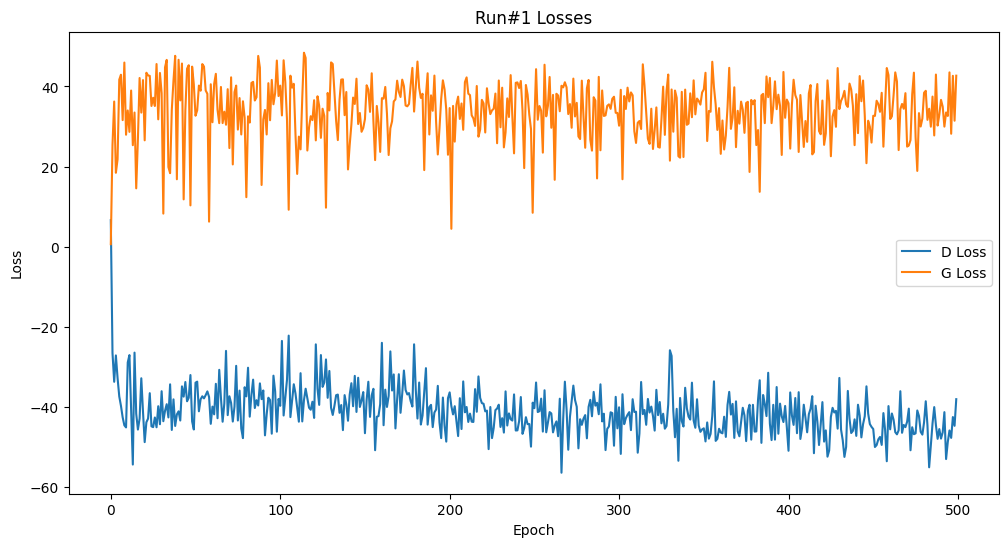

In [43]:
logs.set_index('Epoch')[['D Loss','G Loss']].plot(figsize = (12,6))
plt.title('Run#1 Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [7]:
import torch
import os

torch.save(generator.state_dict(), r"E:\Projects\Data\VW-GAN\Models\generator_epoch500.pth")
torch.save(discriminator.state_dict(), r"E:\Projects\Data\VW-GAN\Models\discriminator_epoch500.pth")